In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# --- CONFIGURATION ---
# The FIX is here: We tell it the project's root is ONE level ABOVE the current notebook folder.
BASE_DIR = os.path.dirname(os.getcwd()) 
DATA_DIR = os.path.join(BASE_DIR, 'datasets', 'lung_data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

print(f"Base Project Directory: {BASE_DIR}")
print(f"Expecting Data In: {DATA_DIR}")

# Check if the main data directory exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"CRITICAL ERROR: The folder '{DATA_DIR}' was not found. Please check your folder names.")
else:
    print("SUCCESS: Found the main data directory.")

# Load the class names from your YAML file
CLASSES = [
    'atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 
    'emphysema', 'fibrosis', 'hernia', 'infiltration', 'mass', 
    'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax'
]

Base Project Directory: c:\Users\Mega-PC\OneDrive\Desktop\LUNG_PROJECT\Lung-AI-Project
Expecting Data In: c:\Users\Mega-PC\OneDrive\Desktop\LUNG_PROJECT\Lung-AI-Project\datasets\lung_data
SUCCESS: Found the main data directory.


In [10]:
def get_data_paths(directory):
    # Check if the specific directory (e.g., train, val) exists first
    if not os.path.exists(directory):
        print(f"WARNING: The directory '{directory}' does not exist. Skipping.")
        return [], []

    image_paths = []
    label_paths = []
    
    # Look for the 'images' subfolder
    image_dir = os.path.join(directory, 'images')
    if os.path.exists(image_dir):
        for file in os.listdir(image_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(image_dir, file))
    else:
        print(f"WARNING: No 'images' folder found inside '{directory}'")

    # Look for the 'labels' subfolder
    label_dir = os.path.join(directory, 'labels')
    if os.path.exists(label_dir):
        for file in os.listdir(label_dir):
            if file.lower().endswith('.txt'):
                label_paths.append(os.path.join(label_dir, file))
    else:
        print(f"WARNING: No 'labels' folder found inside '{directory}'")

    return image_paths, label_paths

train_images, train_labels = get_data_paths(TRAIN_DIR)
val_images, val_labels = get_data_paths(VAL_DIR)

print("\n--- Integrity Check Results ---")
print(f"Train Images Found: {len(train_images)}")
print(f"Train Labels Found: {len(train_labels)}")
print(f"Val Images Found: {len(val_images)}")
print(f"Val Labels Found: {len(val_labels)}")

# Integrity Check: Find images with no corresponding label file
train_image_stems = {os.path.splitext(os.path.basename(p))[0] for p in train_images}
train_label_stems = {os.path.splitext(os.path.basename(p))[0] for p in train_labels}
missing_labels = train_image_stems - train_label_stems
print(f"\nFound {len(missing_labels)} training images with no label file (these are 'Normal' cases).")


--- Integrity Check Results ---
Train Images Found: 3947
Train Labels Found: 3947
Val Images Found: 494
Val Labels Found: 494

Found 0 training images with no label file (these are 'Normal' cases).


In [11]:
def count_classes(label_paths, class_names):
    class_counts = {name: 0 for name in class_names}
    box_data = []
    for label_path in label_paths:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    class_name = class_names[class_id]
                    class_counts[class_name] += 1
                    
                    # Store box data for later analysis
                    x, y, w, h = map(float, parts[1:])
                    box_data.append({'class_name': class_name, 'width': w, 'height': h, 'area': w*h})
                
    return class_counts, pd.DataFrame(box_data)

train_counts, train_boxes_df = count_classes(train_labels, CLASSES)
print("\nTraining Set Class Distribution:")
print(pd.Series(train_counts).sort_values(ascending=False))


Training Set Class Distribution:
emphysema             552
nodule                493
effusion              452
edema                 443
fibrosis              422
pleural_thickening    416
infiltration          403
mass                  373
pneumonia             354
consolidation         340
atelectasis           308
cardiomegaly          302
pneumothorax          249
hernia                162
dtype: int64


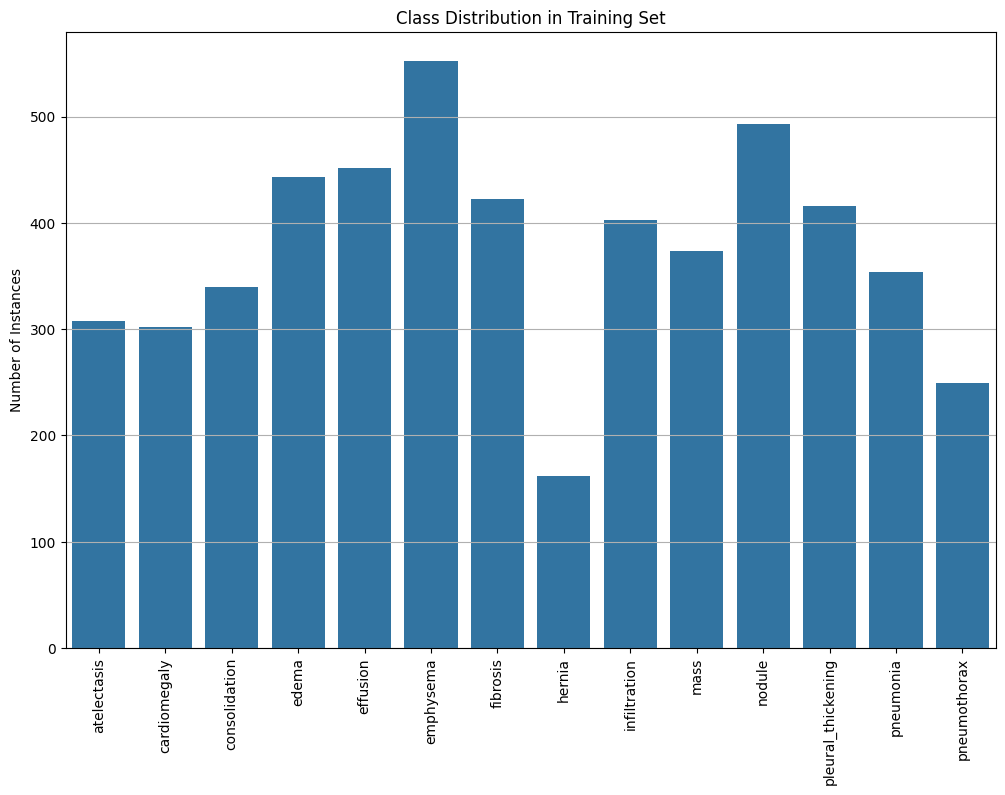


Imbalance Ratio (Max/Min): 3.4x


In [12]:
plt.figure(figsize=(12, 8))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.xticks(rotation=90)
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Instances')
plt.grid(axis='y')
plt.show()

# Report the imbalance ratio
max_count = max(train_counts.values())
min_count = min(train_counts.values())
print(f"\nImbalance Ratio (Max/Min): {max_count / min_count if min_count > 0 else float('inf'):.1f}x")

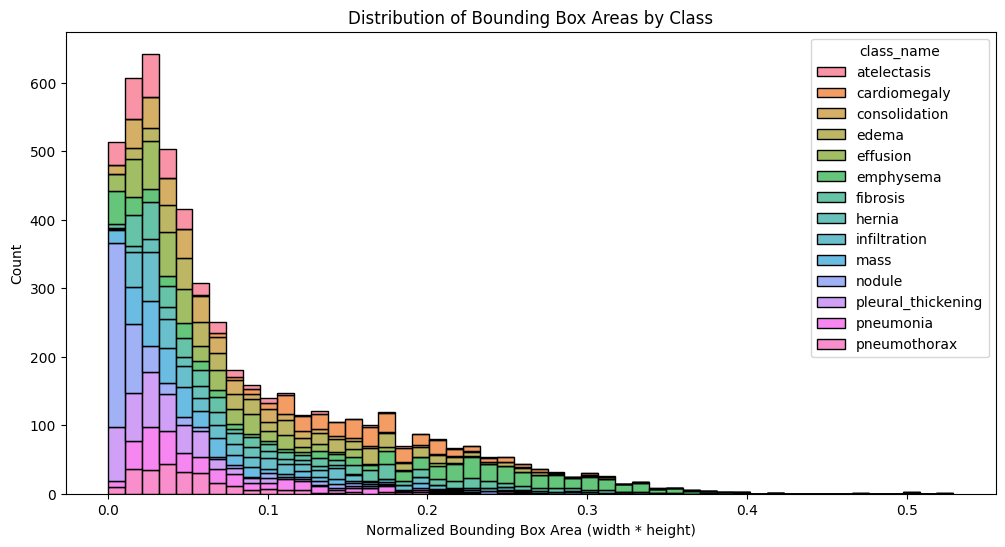


Bounding Box Area Statistics (shows which findings are typically small or large):
                    count      mean       std       min       25%       50%  \
class_name                                                                    
atelectasis         308.0  0.044397  0.043662  0.000006  0.018750  0.031230   
cardiomegaly        302.0  0.163174  0.047753  0.062805  0.127050  0.160357   
consolidation       340.0  0.065019  0.062024  0.000050  0.027574  0.050440   
edema               443.0  0.111088  0.070827  0.000002  0.050801  0.094000   
effusion            452.0  0.062279  0.053548  0.000496  0.026410  0.044725   
emphysema           552.0  0.177470  0.111326  0.000000  0.058242  0.202611   
fibrosis            422.0  0.108970  0.085557  0.000881  0.032626  0.079938   
hernia              162.0  0.071517  0.039835  0.009125  0.038495  0.066770   
infiltration        403.0  0.084523  0.074034  0.009796  0.029526  0.053481   
mass                373.0  0.060219  0.057580  0

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train_boxes_df, x='area', hue='class_name', bins=50, multiple="stack")
plt.title('Distribution of Bounding Box Areas by Class')
plt.xlabel('Normalized Bounding Box Area (width * height)')
plt.show()

print("\nBounding Box Area Statistics (shows which findings are typically small or large):")
print(train_boxes_df.groupby('class_name')['area'].describe())

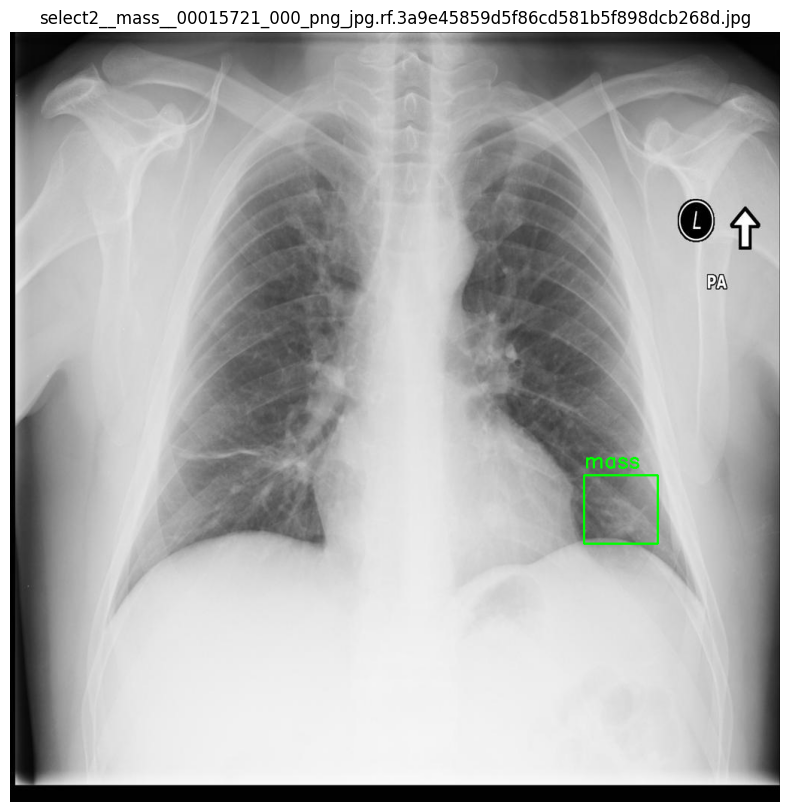

In [14]:
def visualize_sample(image_path, label_path, class_names):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, class_names[class_id], (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

# Visualize a random sample
random_idx = np.random.randint(0, len(train_images))
image_to_show = train_images[random_idx]
label_to_show = image_to_show.replace('images', 'labels').replace('.png', '.txt').replace('.jpg', '.txt')
visualize_sample(image_to_show, label_to_show, CLASSES)